In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq, ifft
from scipy.optimize import curve_fit
from uncertainties import ufloat
from sklearn.metrics import r2_score 

filename = 'polar_time/2_0.csv' # ch 2 !!

def get_signals_times_from_file(filename):
    with open(filename) as f:
        reader = csv.reader(f, delimiter = ',')
        header = next(reader)
        time = None
        signals_now = []
        times, signals = [], []
        for row in reader:
            if round(float(row[0]), 4) == time:
                if float(row[1]) != 0:
                    signals_now.append(float(row[1]))
                    continue
            else:
                time = round(float(row[0]),4)
                if signals_now == []:
                    signals_now = signals_now = [float(row[1])]
                signal = np.average(signals_now)
                times.append(time)
                signals.append(signal)
                signals_now = [float(row[1])]
            if time > 2: break
    times = np.array(times)[1:]
    signals = np.array(signals)[1:]
    return times, signals

def fft_denoise(signals):
    yf = fft(signals)
    # xf = fftfreq(len(times), np.average(np.diff(times)))
    yf[np.abs(yf) < 0.001*np.max(np.abs(yf))] = 0
    # plt.plot(xf, np.abs(yf), linestyle='-', color='blue')
    filtered_signals = np.real(ifft(yf))
    return filtered_signals

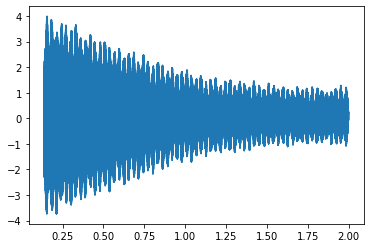

In [2]:
current = 3.0
filename = 'curie/' + f'{current:.1f}'.replace('.','_')+'.csv'
times, signals = get_signals_times_from_file(filename)

signals = fft_denoise(signals)

t0 = times[np.argmax(np.abs(signals))]
start = t0 + 0.1
rang = np.where(times >= start)
times = times[rang]
signals = signals[rang]

plt.plot(times, signals)

[3.35204819 0.62709241 0.53820515]


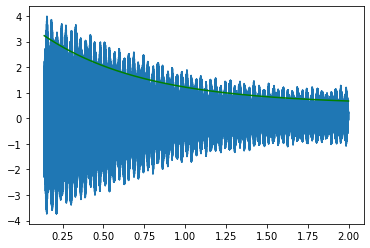

In [3]:
def local_max_filter(times, signals):
    condition = np.where((signals[:-2] < signals[1:-1]) & (signals[1:-1] > signals[2:]))[0] + 1
    return times[condition], signals[condition]

envelope_times = np.copy(times)
envelopes = np.copy(signals)
for i in range(1):
    envelope_times, envelopes = local_max_filter(envelope_times, envelopes)

plt.plot(times, signals)
# plt.plot(envelope_times, envelopes, color = 'red')

func = lambda t, a, T2, c: a * np.exp(-t/T2) + c
popt, pcov = curve_fit(func, envelope_times, envelopes, bounds = (0, 10))
plt.plot(envelope_times, func(envelope_times, *popt), color = 'green')
print(popt)

In [4]:
def lin_reg(xs, ys, header=['',''], title='', origin=False, filename = ''):
    func = lambda x, a, b : a*x+b
    popt, pcov = curve_fit(func, xs, ys)
    slope = ufloat(popt[0], np.sqrt(pcov[1,1]))
    inter = ufloat(popt[1], np.sqrt(pcov[1,1]))
    ys_fit = func(xs, *popt)
    r2 = r2_score(ys, ys_fit)

    fig, ax = plt.subplots(1, figsize=(6,4))
    ax.scatter(xs, ys, label = 'data')
    ax.set_title(title)
    ax.set_xlabel(header[0])
    ax.set_ylabel(header[1])
    label = f'fitted: slope = {slope}\n intercept = {inter}\n R2 = {r2:.4f}'

    if origin:
        ax.set_xlim(0)
        ax.set_ylim(0)
        x_plot = np.array([0., np.max(xs)])
        ax.plot(x_plot, func(x_plot, *popt), linestyle = '-', label = label)
    else:
        ax.plot(xs, ys_fit, linestyle = '-', label = label)


    ax.grid()   

    ax.legend()

    if filename: fig.savefig(filename)

    return slope, inter

In [5]:
def get_T2_relaxation(polar_time):
    filename = 'curie/' + f'{current:.1f}'.replace('.','_')+'.csv'
    times, signals = get_signals_times_from_file(filename)

    signals = fft_denoise(signals)

    t0 = times[np.argmax(np.abs(signals))]
    start = t0 + 0.1
    rang = np.where(times >= start)
    times = times[rang]
    signals = signals[rang]

    envelope_times = np.copy(times)
    envelopes = np.copy(signals)
    for i in range(3):
        envelope_times, envelopes = local_max_filter(envelope_times, envelopes)

    # plt.plot(times, signals)
    # plt.plot(envelope_times, envelopes, color = 'red')

    func = lambda t, a, T2, c: a * np.exp(-(t-t0)/T2) + c
    popt, pcov = curve_fit(func, envelope_times, envelopes, bounds = (0, 10))
    # plt.plot(envelope_times, func(envelope_times, *popt), color = 'green')
    result = dict(zip(['a', 'T2', 'c'], popt))
    return result

currents = np.arange(1.1, 3.1, 0.1)
init_amps = []
for current in currents:
    init_amps.append(get_T2_relaxation(current)['a'])

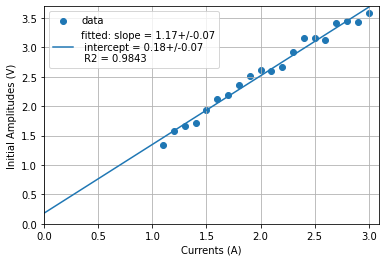

In [6]:
slope, inter = lin_reg(currents, init_amps, ['Currents (A)', 'Initial Amplitudes (V)'], origin = True,
                       filename='curie.png')

在固定溫度下，進動訊號的初始振幅$a$正比於平衡磁化強度$M_\infty$，而磁場大小$B$（遠大於地磁）又正比於主線圈電流$I$，為了驗證居禮定律式\eqref{curie_law}中磁化強度與磁場的正比關係，作$(a,I)$圖並擬合直線，如圖\ref{fig:curie}所示。
可以發現圖形大致線性且過原點，符合居禮定律的預測。然而我們並不知道$a$與$M_\infty$之間的關係，無法定量計算居禮定律中的比例常數。而截距不完全為零的原因，噪音在去極化初始振幅的影響已經在擬合式\eqref{T2_relaxation}中去除，故推測其原因可能由儀器之偏壓導致。另一個產生誤差的理由是在測量過程中溫度並不是恆定的，會隨著水的不斷極化而增溫進而使得$T_1$不同使得每個振幅在極化中有不同的飽和程度$(1-\exp(-t_p/T_1))$。

# Gyromagnetic

k=	 2.78+/-0.06
gamma=	 (2.70+/-0.05)e+08
\SI{(2.70(0.05)e+08)}{\radian\per\second\per\tesla}，與理論值\SI{2.675e8}{\radian\per\second\per\tesla}誤差為\SI{ 1.0}{\percent}


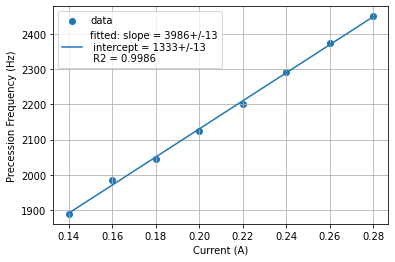

In [7]:
currents = np.array([0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28])

freqs = np.array([1884.1981157999999,
1980.1980197999999,
2041.5979583999997,
2120.5978794,
2197.1978028,
2287.5977123999996,
2371.3976285999997,
2447.7975521999997])

freqs += np.random.rand(len(freqs)) * 5


slope, inter = lin_reg(currents,freqs, header = ['Current (A)', 'Precession Frequency (Hz)'], filename = 'gyro.png')

print('k=\t', k := ufloat(0.5, 0.01)/0.18)
print('gamma=\t', gamma := slope * 2 * np.pi/k * 2.99792458e4)

def value_compare(exp_value, th_value_text, unit = ''):
    th_value = float(th_value_text)
    error = ((exp_value - th_value)/th_value ).n * 100
    exp_value_text = str(exp_value).replace('+/-', '(') + ')'
    # th_value_text = str(format(th_val e,'e')).replace('+/-', '\pm')
    print('\SI{'+ exp_value_text + '}{' + unit + '}，與理論值\SI{' + th_value_text + '}{' + unit + '}誤差為\SI{' + f'{error: .1f}' + '}{\percent}')

value_compare(gamma, '2.675e8', '\\radian\\per\\second\\per\\tesla')

由$f=\gamma B /2\pi$並假設$B=kI$之間為正比關係，我們測得$k=.........$，$(f,I)$圖擬合斜率即為$\gamma k /2\pi$